# SR3 Reader

* Reads data from SR3 file (HDF).
* Return groups, wells, special and grid properties list.
* Return 2D and 3D Time vector.
* Return a 2D or 3D property.
* Save all data to a csv file.

In [1]:
import h5py
from datetime import datetime, timedelta
import re
import numpy as np
from scipy import interpolate
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib
params = {'font.size'     : 10,
          'figure.figsize':(8.0, 5.0),
          'lines.linewidth': 1.,
          'lines.markersize': 7,}
matplotlib.rcParams.update(params)

%matplotlib inline

In [2]:
f = h5py.File(r'..\sr3\base_case_3a.sr3', 'r')

In [3]:
def _list_hdf_():
    print("Main Groups in the HDF file:")
    for dataset in f.keys():
        print(f'  {dataset}')

    print("\nAll Groups in the HDF file:")
    def get_type(name):
        print(f'   {name:}\t{type(f[name])}')
    f.visit(get_type)

## Master Data

In [4]:
dataset = f['General/MasterTimeTable']
day_list = {number:days for (number,days) in zip(dataset['Index'], dataset['Offset in days'])}

def parse_date(date):
    date_string = str(date)
    integer_part = int(date_string.split('.')[0])
    decimal_part = float("0." + date_string.split('.')[1])

    parsed_date = datetime.strptime(str(integer_part), "%Y%m%d")
    fraction_of_day = timedelta(days=decimal_part)
    return parsed_date + fraction_of_day

dataset = f['General/MasterTimeTable']
date_list = {number:parse_date(date) for (number,date) in zip(dataset['Index'], dataset['Date'])}

In [5]:
dataset = f['General/UnitsTable']
unit_list = {number:{'type':name.decode().lower(), 'internal':in_name.decode(), 'current':out_name.decode(), 'conversion':dict()} for (number,name,in_name,out_name) in zip(dataset['Index'],dataset['Dimensionality'],dataset['Internal Unit'],dataset['Output Unit'])}

dataset = f['General/UnitConversionTable']
for (number, name, gain, offset) in zip(dataset['Dimensionality'],dataset['Unit Name'],dataset['Gain'],dataset['Offset']):
    unit_list[number]['conversion'][name.decode()] = (1./gain, offset * (-1.))

for d in unit_list.values():
    if d['internal'] != d['current']:
        gain, offset = d['conversion'][d['internal']]
        for k in d['conversion']:
            g, o = d['conversion'][k]
            d['conversion'][k] = (g / gain, o - offset)

for unit in unit_list.values():
    if unit['internal'] not in unit['conversion']:
        unit['conversion'][unit['internal']] = (1.,0.)

In [6]:
dataset = f['General/ComponentTable']
component_list = {(number+1):name[0].decode() for (number,name) in enumerate(dataset[:])}

def replace_components_property_list(property_list):
    pattern = re.compile(r'\((\d+)\)')
    def replace(match):
        number = int(match.group(1))
        return f'({str(component_list.get(number, match.group(1)))})'
    return {pattern.sub(replace, k):v for k,v in property_list.items()}

In [7]:
dataset = f['General/NameRecordTable']
property_list = dict()
for (keyword,name,long_name,dimensionality) in zip(dataset['Keyword'],dataset['Name'],dataset['Long Name'],dataset['Dimensionality']):
    if keyword != '':
        keyword = keyword.decode()
        name = name.decode()
        long_name = long_name.decode()
        dimensionality = dimensionality.decode()
        if keyword[-2:] == '$C':
            for c in component_list.values():
                property_list[f'{keyword[:-2]}({c})'] = {'name':name.replace('$C', f' ({c})'), 'long name':long_name.replace('$C', f' ({c})'), 'dimensionality_string':dimensionality}
        else:
            property_list[keyword] = {'name':name, 'long name':long_name, 'dimensionality_string':dimensionality}

In [8]:
def _unit_from_dimensionality(dimensionality_string):
    if dimensionality_string == '':
        return ''
    unit = ''
    if dimensionality_string[0] == '-':
        unit = '1'
    d = ''
    for c in dimensionality_string:
        if c == '|':
            unit = unit + unit_list[int(d)]['current']
            d = ''
        elif c == '-':
            unit = unit + '/'
        else:
            d = d + c
    return unit

def _unit_conversion_from_dimensionality(dimensionality_string, is_delta=False):
    if dimensionality_string == '':
        return (1., 0.)
    gain = 1.
    offset = 0.
    inverse = False
    if dimensionality_string[0] == '-':
        inverse = True
    d = ''
    for c in dimensionality_string:
        if c == '|':
            unit = unit_list[int(d)]['current']
            gain_new, offset_new = unit_list[int(d)]['conversion'][unit]
            d = ''
            if inverse:
                gain = gain / gain_new
                offset = 0.
            else:
                gain = gain * gain_new
                if is_delta:
                    offset = 0.
                else:
                    offset = offset * gain_new + offset_new
        elif c == '-':
            inverse = True
        else:
            d = d + c
    return (gain, offset)

def _update_properties_units():
    for p in property_list:
        property_list[p]['conversion'] = _unit_conversion_from_dimensionality(property_list[p]['dimensionality_string'])
        property_list[p]['unit'] = _unit_from_dimensionality(property_list[p]['dimensionality_string'])

def _get_unit_type_number(dimensionality):
    if isinstance(dimensionality, str):
        d = [d for d in unit_list if unit_list[d]['type'] == dimensionality.lower()]
        if len(d) == 0:
            raise ValueError(f'{dimensionality} is not a valid unit type.')
        if len(d) > 1:
            raise ValueError(f'{dimensionality} found more than once. Check code.')
        return d[0]
    else:
        return dimensionality

def set_current_unit(dimensionality, unit):
    dimensionality = _get_unit_type_number(dimensionality)
    if unit not in unit_list[dimensionality]['conversion']:
        raise ValueError(f'{unit} is not a valid unit for {unit_list[dimensionality]['type']}.')
    unit_list[dimensionality]['current'] = unit
    _update_properties_units()

def get_current_units():
    for d in unit_list.values():
        print(f'{d["type"]}: {d["current"]}')

In [9]:
def _get_unit_numbers(unit):
    out = list()
    for u in unit_list:
        for c in unit_list[u]['conversion']:
            if unit == c:
                out.append(u)
    return out

def add_new_unit(old_unit, new_unit, gain, offset):
    unit_numbers = _get_unit_numbers(old_unit)
    if len(unit_numbers) == 0:
        raise ValueError(f'{old_unit} was not found in Units Table.')

    for u in unit_numbers:
        g, o = unit_list[u]['conversion'][old_unit]
        unit_list[u]['conversion'][new_unit] = (g * gain, o * gain + offset)

In [10]:
def get_property_description(property_):
    return {'description': property_list[property_]['name'],
            'long description': property_list[property_]['long name'],
            'unit': property_list[property_]['unit']
            }

def get_property_unit(property_):
    return property_list[property_]['unit']

In [11]:
additional_units = [('m3', 'MMm3', (1.e-6, 0.0)),
                    ('bbl', 'MMbbl', (1.e-6, 0.0)),
                    ('kg/cm2', 'kgf/cm2', (1., 0.0)),
                    ]

for old, new, (gain, offset) in additional_units:
    add_new_unit(old, new, gain, offset)

set_current_unit('pressure','kgf/cm2')
get_current_units()

time: day
temperature: C
pressure: kgf/cm2
length: m
property volume: m3
permeability: md
mass: kg
molar mass: gmole
viscosity: cp
energy: J
well liquid volume: m3
well gas volume: m3
well rate time: day
interfacial tension: dyne/cm
electrical current: A
electrical power: J/day
electrical potential: V
electrical resistance: ohm
electrical conductivity: S/m
electrical energy: J
temperature difference: C
diffusion/dispersion coeff.: cm2/s
concentration: kg/m3
molar concentration: gmole/m3


### Property Formulas (todo)

* Basic
    * 1035: sum (2 parameters)
    * 1037: sum (3 parameters)

* Time derivatives
    * 1040: derivative (1 parameter)
    * 1045: monthly derivative (1 parameter)
    * 1046: quarterly derivative (1 parameter)
    * 1047: yearly derivative (1 parameter)
    * 1048: daily derivative (1 parameter)
    * 1049: weekly derivative (1 parameter)

* Percentage
    * 1055: A*100 (1 parameter)

* Division
    * 1060: division (2 parameters)
    * 1062: division * 100 (2 parameters) <= used with on-fraction

    * 1080: division (2 parameters)

* Previous month
    * 1121: monthly derivative of previous month (1 parameter)
    * 1122: yearly derivative of previous month (1 parameter)

* Grid properties(?)
    * 1130: A*grid height (1 parameter)
    * 1140: A/(B*C) ? (3 parameters)
    * 1160: A*B (2 parameters)
    * 1200: ternary (2 parameters)
    * 1210: sum over layers (1 parameter)

* Per sector
    * 1110: ??? (1 parameter) <= per sector
    * 1245: ??? (1 parameter) <= per sector
    * 1246: derivative of 1245 (1 parameter) 



## Common Routines

In [12]:
def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False
    
def remove_duplicates(input_list):
    unique_items = OrderedDict()
    for item in input_list:
        unique_items[item] = None
    return list(unique_items.keys())

## Time Series

In [66]:
_element = {'special':{'':0}, 'grid':{'MATRIX':0}}
_parent = dict()
_connection = dict()
_property = dict()
_timestep = dict()
_day = dict()
_date = dict()

def _return_dataset(element_type, dataset_string):
    el_type_string = element_type.upper()
    if element_type == 'special':
        el_type_string = el_type_string + ' HISTORY'
    else:
        el_type_string = el_type_string + 'S'
    s = f'TimeSeries/{el_type_string}/{dataset_string}'
    if s in f:
        return f[s]
    else:
        raise ValueError(f'Dataset {dataset_string} not found for {element_type}. TimeSeries/{el_type_string}/{dataset_string} does not exist.')
    
def get_elements(element_type):        
    if element_type not in _element:
        dataset = _return_dataset(element_type=element_type, dataset_string='Origins')
        _element[element_type] = {name.decode():number for (number,name) in enumerate(dataset[:]) if name.decode()!=''}
    return _element[element_type]

def get_properties(element_type):
    if element_type not in _property:
        if element_type == 'grid':
            _property[element_type] = _get_grid_properties()
        else:
            dataset = _return_dataset(element_type=element_type, dataset_string='Variables')
            _property[element_type] = {name.decode():number for (number,name) in enumerate(dataset[:])}
            _property[element_type] = replace_components_property_list(_property[element_type])
    return _property[element_type]

def get_timesteps(element_type):
    if element_type not in _timestep:
        if element_type == 'grid':
            _timestep[element_type] = _get_grid_timesteps()
        else:    
            dataset = _return_dataset(element_type=element_type, dataset_string='Timesteps')
            _timestep[element_type] = dataset[:]
    return _timestep[element_type]

def get_days(element_type):
    if element_type not in _day:
        timesteps = get_timesteps(element_type=element_type)
        _day[element_type] = np.vectorize(lambda x: day_list[x])(timesteps)
    return _day[element_type]

def get_dates(element_type):
    if element_type not in _date:
        timesteps = get_timesteps(element_type=element_type)
        _date[element_type] = np.vectorize(lambda x: date_list[x])(timesteps)
    return _date[element_type]

def _get_parents(element_type):
    if element_type in ['well', 'group', 'layer']:
        dataset = _return_dataset(element_type=element_type, dataset_string=f'{element_type.capitalize()}Table')
        def _name(name, parent):
            if element_type == 'layer':
                return f'{parent.decode()}{{{name.decode()}}}'
            else:
                return name.decode()
        _parent[element_type] = {_name(name, parent):parent.decode() for (name,parent) in zip(dataset['Name'], dataset['Parent'])}
    else:
        _parent[element_type] = {name:'' for name in get_elements(element_type)}

def get_parent(element_type, element_name):
    if element_type not in _parent:
        _get_parents(element_type)
    return _parent[element_type][element_name]

def _get_connections(element_type):
    if element_type == 'layer':
        dataset = _return_dataset(element_type=element_type, dataset_string=f'{element_type.capitalize()}Table')
        def _name(name, parent):
            return f'{parent.decode()}{{{name.decode()}}}'
        _connection[element_type] = {_name(name, parent):connection for (name,parent,connection) in zip(dataset['Name'], dataset['Parent'], dataset['Connect To'])}
    else:
        _connection[element_type] = {name:'' for name in get_elements(element_type)}

def get_connection(element_type, element_name):
    if element_type not in _connection:
        _get_connections(element_type)
    return _connection[element_type][element_name]


In [67]:
def _get_grid_sizes():
    dataset = f['SpatialProperties/000000/GRID']
    ni = dataset['IGNTID'][0]
    nj = dataset['IGNTJD'][0]
    nk = dataset['IGNTKD'][0]
    n_active = dataset['IPSTCS'].size
    return ni, nj, nk, n_active

def _get_grid_timesteps():
    dataset = f['SpatialProperties']
    grid_timestep_list = list()
    for key in dataset.keys():
        sub_dataset = f[f"SpatialProperties/{key}"]
        if isinstance(sub_dataset, h5py._hl.group.Group):
            grid_timestep_list.append(int(key))
    return np.array(grid_timestep_list)

In [77]:
def _get_grid_properties():
    dataset = f['SpatialProperties/Statistics']
    grid_property_list = {name.decode().replace('/','%2F'):{'min':min_, 'max':max_, 'timesteps':set(), 'is_internal':False, 'is_complete':False} for name,min_,max_ in zip(dataset['Keyword'],dataset['Min'],dataset['Max'])}

    ni, nj, nk, n_active = _get_grid_sizes()
    n_cells = ni*nj*nk

    def _list_grid_properties(timestep, add_timestep=True):
        dataset = f[f'SpatialProperties/{timestep}']
        for key in dataset.keys():
            sub_dataset = f[f"SpatialProperties/{timestep}/{key}"]
            if isinstance(sub_dataset, h5py._hl.dataset.Dataset):
                if key in grid_property_list:
                    size = sub_dataset.size
                    if size in [n_cells, n_active]:
                        if 'size' in grid_property_list[key]:
                            if grid_property_list[key]['size'] != sub_dataset.size:
                                raise ValueError(f'Inconsistent grid size for {key}.')
                        else:
                            grid_property_list[key]['size'] = sub_dataset.size
                            grid_property_list[key]['is_complete'] = sub_dataset.size == n_cells
                        if add_timestep:
                            grid_property_list[key]['timesteps'].add(int(timestep))
                        else:
                            grid_property_list[key]['is_internal'] = True
                    else:
                        _ = grid_property_list.pop(key)
                else:
                    raise ValueError(f'{key} not listed previously!')

    _list_grid_properties('000000/GRID', False)
    for ts in get_timesteps('grid'):
        _list_grid_properties(str(ts).zfill(6))
    return grid_property_list

### Get Data

In [44]:
def _concatenate_arrays(arr1, arr2):
    if arr1.ndim == 1:
        arr1 = arr1.reshape(-1,1)
    if arr2.ndim == 1:
        arr2 = arr2.reshape(-1,1)
    return np.hstack((arr1, arr2))

def _data_unit_conversion(data, property_name):
    n_data_columns = data.shape[1]

    if isinstance(property_name, str):
        property_name = [property_name]
    
    n_properties = len(property_name)
    n_elements = int(n_data_columns / n_properties)
    for i_property,p in enumerate(property_name):
        gain, offset = property_list[p]['conversion']
        if gain != 1.0 or offset != 0.0:
            for i_element in range(n_elements):
                k = i_property + i_element * n_properties
                data[:,k] = data[:,k] * gain + offset

def _get_dataset_2D_data(dataset, param1, param2):
    def _ordered_x(x):
        if isinstance(x, list):
            x_ordered = list(set(x)).copy()
            x_ordered.sort()
        return x_ordered
    x1 = _ordered_x(param1)
    x2 = _ordered_x(param2)
    
    indexes = []
    if len(x1) > len(x2):
        data = dataset[:,x1,x2[0]]
        indexes.extend([(xi,x2[0]) for xi in x1])
        for x in x2[1:]:
            data = _concatenate_arrays(data, dataset[:,x1,x])
            indexes.extend([(xi,x) for xi in x1])
    else:
        data = dataset[:,x1[0],x2]
        indexes.extend([(x1[0],xi) for xi in x2])
        for x in x1[1:]:
            data = _concatenate_arrays(data, dataset[:,x,x2])
            indexes.extend([(x,xi) for xi in x2])

    original_index = []
    for p2 in param2:
        for p1 in param1:
            original_index.append((p1,p2))
    order = [indexes.index(x) for x in original_index]

    return data[:, order]

def _get_raw_data(element_type, property_names, element_names=[''], with_dates=False, with_days=False, with_timesteps=False):
    def _get_indexes(name_list, index_dict):
        if isinstance(name_list, list):
            return [index_dict[name] for name in name_list]
        else:
            return [index_dict[name_list]]

    property_indexes = _get_indexes(property_names, get_properties(element_type))
    element_indexes = _get_indexes(element_names, get_elements(element_type))

    dataset = _return_dataset(element_type=element_type, dataset_string='Data')

    data = _get_dataset_2D_data(dataset, property_indexes,element_indexes)
    _data_unit_conversion(data, property_names)

    if with_dates:
        return _concatenate_arrays(get_dates(element_type=element_type), data)
    elif with_days:
        return _concatenate_arrays(get_days(element_type=element_type), data)
    elif with_timesteps:
        return _concatenate_arrays(get_timesteps(element_type=element_type), data)
    else:
        return data
    
def _get_interp_data(days, element_type=None, property_names=None, element_names=[''], raw_data=None):
    if raw_data is None:
        raw_data = _get_raw_data(element_type=element_type, property_names=property_names, element_names=element_names, with_days=True)
    data = np.array(days)
    for i in range(1, raw_data.shape[1]):
        interp = interpolate.interp1d(raw_data[:,0], raw_data[:,i], kind = "linear")
        y = interp(days)
        data = _concatenate_arrays(data, y)
    return data

def get_data(days=None, element_type=None, property_names=None, element_names=[''], raw_data=None):
    if raw_data is None:
        raw_data = _get_raw_data(element_type=element_type, property_names=property_names, element_names=element_names, with_days=True)
    if days is None:
        data = raw_data
    else:
        data = _get_interp_data(days=days, raw_data=raw_data)
    return data

def get_series_order(property_names, element_names=['']):
    if isinstance(property_names, str):
        property_names = [property_names]
    if isinstance(element_names, str):
        element_names = [element_names]

    original_index = []
    for element in element_names:
        for property_ in property_names:
            original_index.append((element, property_))
    return original_index

## Plotting

In [41]:
def _align_y_axis(ax1, ax2):
    n_extra_ticks = len(ax1.get_yticks()) - len(ax2.get_yticks())       
    if n_extra_ticks > 0:
        ax_a = ax1
        ax_b = ax2
    elif n_extra_ticks < 0:
        ax_a = ax2
        ax_b = ax1
    else:
        return
    n_extra_ticks = abs(n_extra_ticks)
    
    ya_min, ya_max = ax_a.get_ylim()
    ya_ticks = ax_a.get_yticks()
    yb_ticks = ax_b.get_yticks()

    delta = (yb_ticks[-1] - yb_ticks[0]) / (len(yb_ticks) - 1)
    yb_ticks = np.linspace(yb_ticks[0],yb_ticks[-1] + n_extra_ticks * delta, len(ya_ticks))
    ax_b.set_yticks(yb_ticks)

    lower_delta = (ya_ticks[1] - ya_min) / (ya_ticks[-2] - ya_ticks[1])
    upper_delta = (ya_max - ya_ticks[-2]) / (ya_ticks[-2] - ya_ticks[1])
    ax_b.set_ylim(yb_ticks[1] - (yb_ticks[-2] - yb_ticks[1]) * lower_delta,
                    yb_ticks[-2] + (yb_ticks[-2] - yb_ticks[1]) * upper_delta)
    return

def get_data_and_plot(days=None, element_type=None, property_names=None, element_names=[''], data=None, keep_all_zeros_series=True, line_styles=None, keep_legend_outside=False, use_secondary_axis=False):
    if data is None:
        data = get_data(days=days, element_type=element_type, property_names=property_names, element_names=element_names)
    series_names = get_series_order(property_names=property_names, element_names=element_names)

    if line_styles is None:
        line_styles = ['-' for _ in range(len(series_names))]
    
    _, ax1 = plt.subplots()
    is_second_axis = set()
    if use_secondary_axis:
        ax2 = ax1.twinx()
        if len(property_names) == 2:
            is_second_axis.add(property_names[1])
        elif len(property_names) > 2:
            first_unit = get_property_unit(property_names[0])
            for p in property_names[1:]:
                if get_property_unit(p) != first_unit:
                    is_second_axis.add(p)

    x = data[:,0]
    property_ploted = list()
    property_ploted_second_axis = list()
    for i, (element, property_) in enumerate(series_names):
        if (keep_all_zeros_series) or (not min(data[:,i+1])==max(data[:,i+1])==0):
            if property_ in is_second_axis:
                ax2.plot(x,data[:,i+1], line_styles[i], label = f"{element}: {property_}")
                property_ploted_second_axis.append(property_)
            else:
                ax1.plot(x,data[:,i+1], line_styles[i], label = f"{element}: {property_}")
                property_ploted.append(property_)
    
    ax1.grid()
    ax1.set_xlabel("days")
    ax1.set_ylabel(', '.join([f'{property_} [{get_property_unit(property_)}]' for property_ in remove_duplicates(property_ploted)]))
    if use_secondary_axis:
        ax2.set_ylabel(', '.join([f'{property_} [{get_property_unit(property_)}]' for property_ in remove_duplicates(property_ploted_second_axis)]))
    
    plt.title('\n'.join([f'{get_property_description(property_)["long description"]}' for property_ in remove_duplicates(property_ploted +  property_ploted_second_axis)]))

    if use_secondary_axis:
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        if keep_legend_outside:
            ax1.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))
        else:
            ax1.legend(lines + lines2, labels + labels2, loc='best')
    else:
        if keep_legend_outside:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            plt.legend(loc='best')

    x_min, x_max = ax1.get_xlim()
    x_ticks = ax1.get_xticks()
    if len(x_ticks) < 8:
        new_ticks = [(x_ticks[i] + x_ticks[i+1])/2 for i in range(len(x_ticks)-1)]
        ax1.set_xticks(list(x_ticks) + new_ticks)
        ax1.set_xlim(x_min, x_max)

    if use_secondary_axis:
        _align_y_axis(ax1, ax2)

    plt.show()

## Tests

In [79]:
_element = {'special':{'':0}, 'grid':{'MATRIX':0}}
_parent = dict()
_connection = dict()
_property = dict()
_timestep = dict()
_day = dict()
_date = dict()

for el_type in ['well', 'group', 'sector', 'layer', 'special', 'grid']:
    print(el_type)
    print(f'  Timesteps:   {get_timesteps(el_type)[:3]}')
    print(f'  Days:        {get_days(el_type)[:3]}')
    print(f'  Dates:       {[d.strftime("%Y-%m-%d %H:%M:%S") for d in get_dates(el_type)[:2]]}')
    print(f'  Properties:  {get_properties(el_type)}')
    print(f'  Elements:    {get_elements(el_type)}')
    _get_parents(el_type)
    print(f'  Parents:     {_parent[el_type]}')
    _get_connections(el_type)
    print(f'  Connections: {_connection[el_type]}')

well
  Timesteps:   [ 9 25 26]
  Days:        [30.   59.99 60.  ]
  Dates:       ['2018-10-02 00:00:00', '2018-10-31 23:45:36']
  Properties:  {'WELLSTATE': 0, 'WELLOPMO': 1, 'WHP': 2, 'BHP': 3, 'BLOCKP': 4, 'MOBWTDATP': 5, 'BHTEMP': 6, 'WHTEMP': 7, 'ONFRAC': 8, 'CGLIFT': 9, 'OILVOLSC': 10, 'GASVOLSC': 11, 'WATVOLSC': 12, 'INLVOLSC': 13, 'WTGVOLSC': 14, 'OILVOLRC': 15, 'GASVOLRC': 16, 'WATVOLRC': 17, 'BHFVOLRC': 18, 'WELLOTIME': 19, 'OILRATSC': 20, 'GASRATSC': 21, 'WATRATSC': 22, 'INLRATSC': 23, 'WTGRATSC': 24, 'OILRATRC': 25, 'GASRATRC': 26, 'WATRATRC': 27, 'BHFRATRC': 28, 'LIQVOLSC': 29, 'LIQRATSC': 30, 'OILMOLSC': 31, 'GASMOLSC': 32, 'WTGMOLSC': 33, 'OILMOLRSC': 34, 'GASMOLRSC': 35, 'WTGMOLRSC': 36, 'OILCMOLSC(CO2)': 37, 'OILCMOLSC(N2 toCH4)': 38, 'OILCMOLSC(C2HtoNC5)': 39, 'OILCMOLSC(C6ttoC19)': 40, 'OILCMOLSC(C29toC63)': 41, 'OILMOLRSC(CO2)': 42, 'OILMOLRSC(N2 toCH4)': 43, 'OILMOLRSC(C2HtoNC5)': 44, 'OILMOLRSC(C6ttoC19)': 45, 'OILMOLRSC(C29toC63)': 46, 'GASCMOLSC(CO2)': 47, 'GASCM

### Examples

In [33]:
get_data(days=[45, 60, 75, 90], element_type='well', property_names=['OILRATSC','BHP','GASRATSC'], element_names=['P11','P12','I11'])

array([[4.50000000e+01, 6.24652603e+03, 6.07279910e+02, 2.69174217e+06,
        0.00000000e+00, 6.39546978e+02, 0.00000000e+00, 0.00000000e+00,
        6.77407607e+02, 2.75869437e+06],
       [6.00000000e+01, 6.39410665e+03, 5.95901890e+02, 2.75533735e+06,
        0.00000000e+00, 6.39546981e+02, 0.00000000e+00, 0.00000000e+00,
        6.90145027e+02, 2.76372039e+06],
       [7.50000000e+01, 6.39410282e+03, 5.93566244e+02, 2.75533570e+06,
        0.00000000e+00, 6.39546980e+02, 0.00000000e+00, 0.00000000e+00,
        6.89217311e+02, 2.76372039e+06],
       [9.00000000e+01, 6.38274358e+03, 5.91267323e+02, 2.75044080e+06,
        0.00000000e+00, 6.39546979e+02, 0.00000000e+00, 0.00000000e+00,
        6.88629388e+02, 2.73261380e+06]])

In [34]:
y = get_data(days=[45, 60, 75, 90], element_type='well',property_names='BHP',element_names='P11')

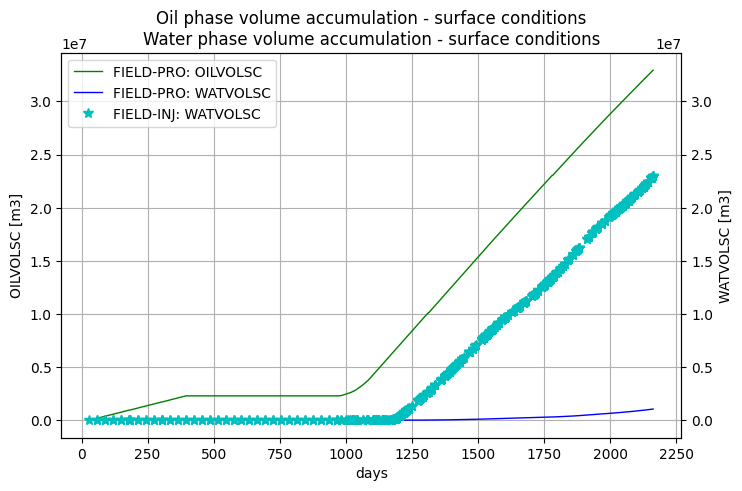

In [35]:
get_data_and_plot(element_type='group', property_names=['OILVOLSC','WATVOLSC'], element_names=['FIELD-PRO','FIELD-INJ'], 
                  keep_all_zeros_series=False, 
                  line_styles=['g-','b-','g-','c*'], 
                  use_secondary_axis=True,
                  keep_legend_outside=False)

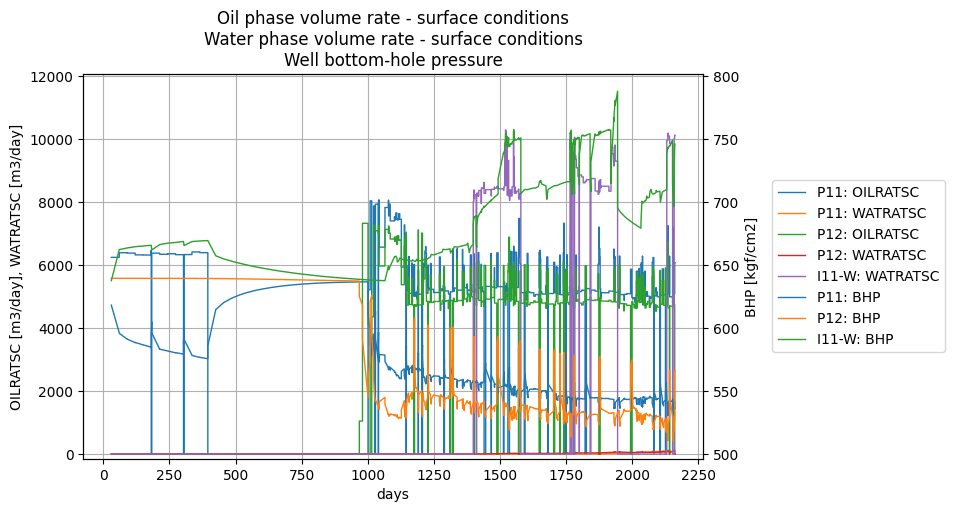

In [36]:
get_data_and_plot(element_type='well', property_names=['OILRATSC','WATRATSC', 'BHP'], element_names=['P11','P12','I11-W'], 
                  keep_all_zeros_series=False, 
                  keep_legend_outside=True, 
                  use_secondary_axis=True)

## Grid Properties

In [60]:
ni, nj, nk, n_active = _get_grid_sizes()
n_cells = ni*nj*nk
print(f'{ni}x{nj}x{nk} = {format(n_cells,",")} cells')
print(f'active: {format(n_active,",")} cells ({(n_active/n_cells*100):.2f}%)')

47x39x291 = 533,403 cells
active: 67,241 cells (12.61%)


* Função para retornar i,j,k em função do cell_#
* Retornar dados de grid com o get_data
* Fazer interpolação de dados de grid
* Distinguir entre propriedades de malha completos e só de células ativas
* Montar array 3D com dados de malha completos
* Montar array 3D com dados de malha só de células ativas

* Retornar lista de propriedades com as funções get_properties
    * Limitar às propriedades de grid completas e de células ativas.
* Get_elements vai ser apenas MATRIX

* Montar propriedades específicas de coordenadas de célula.

In [23]:
n_active_cells = grid_property_list['IPSTCS']['size']
print(f'Number of active cells: {n_active_cells}')

Number of active cells: 67241


In [24]:
dataset = f['SpatialProperties/000000/GRID']
for key in dataset.keys():
    sub_dataset = f[f"SpatialProperties/000000/GRID/{key}"]
    size = '{:,}'.format(sub_dataset.size)
    print(f'  {key}: {size} -> {property_list[key]["long name"]}')

  BLOCKDEPTH: 533,403 -> Grid block depths for all layers
  BLOCKPVOL: 67,241 -> Block pore volume
  BLOCKS: 4,267,224 -> Grid Block connectivity of Node Based Corner Point Grid
  BLOCKSIZE: 1,600,209 -> Grid block sizes in three directions
  BVOL: 67,241 -> Gross Block Volume = dx*dy*dz
  ICNTDR: 176,572 -> Connection direction
  ICSTBC: 533,403 -> Complete storage to block type
  ICSTCG: 533,403 -> Complete storage to child grid
  ICSTGN: 533,403 -> Complete storage to grid number
  ICSTPB: 533,403 -> Complete storage to parent block
  ICSTPS: 533,403 -> Complete storage to packed storage
  ICTPS1: 176,572 -> Connection to lower packed storage
  ICTPS2: 176,572 -> Connection to upper packed storage
  IGNTFR: 1 -> Grid number to first fracture CS index
  IGNTGT: 1 -> Grid number to grid type
  IGNTID: 1 -> Grid number to no. of I direction blocks
  IGNTJD: 1 -> Grid number to no. of J direction blocks
  IGNTKD: 1 -> Grid number to no. of K direction blocks
  IGNTNC: 2 -> Grid number t

In [25]:
{p:grid_property_list[p] for p in grid_property_list if len(grid_property_list[p]['timesteps'])==0}

{'ICSTBC': {'min': -2.0, 'max': 0.0, 'timesteps': set(), 'size': 533403},
 'ICSTCG': {'min': 0.0, 'max': 0.0, 'timesteps': set(), 'size': 533403},
 'ICSTGN': {'min': 1.0, 'max': 1.0, 'timesteps': set(), 'size': 533403},
 'ICSTPS': {'min': 0.0, 'max': 67241.0, 'timesteps': set(), 'size': 533403},
 'ICSTPB': {'min': 1.0, 'max': 533403.0, 'timesteps': set(), 'size': 533403},
 'IPSTCS': {'min': 373.0, 'max': 533075.0, 'timesteps': set(), 'size': 67241},
 'IPSTBT': {'min': 9.0, 'max': 9.0, 'timesteps': set(), 'size': 67241},
 'IPSTAC': {'min': 1.0, 'max': 1.0, 'timesteps': set(), 'size': 67241},
 'IGNTID': {'min': 47.0, 'max': 47.0, 'timesteps': set(), 'size': 1},
 'IGNTJD': {'min': 39.0, 'max': 39.0, 'timesteps': set(), 'size': 1},
 'IGNTKD': {'min': 291.0, 'max': 291.0, 'timesteps': set(), 'size': 1},
 'IGNTZA': {'min': 0.0, 'max': 0.0, 'timesteps': set(), 'size': 1},
 'IGNTGT': {'min': 12.0, 'max': 12.0, 'timesteps': set(), 'size': 1},
 'IGNTFR': {'min': 533404.0, 'max': 533404.0, 'times

## Get Coordinates

In [26]:
_CHUNK_SIZE = 1200

def expand_list(original_list, items=1):
    expanded_list = []
    for value in original_list:
        value_shift = (value-1)*items
        expanded_list.append(value_shift)
        for new_value in range(value_shift + 1, value_shift + items):
            expanded_list.append(new_value)
    return expanded_list

def get_dataset_data(dataset, values_list):
    if not is_iterable(values_list):
        return dataset[values_list]
    x_ordered = list(set(values_list)).copy()
    x_ordered.sort()
    sub_x_ordered = np.array_split(x_ordered, int(len(x_ordered)/_CHUNK_SIZE)+1)
    y_dict = dict()
    for x in sub_x_ordered:
        y = dataset[x]
        for x,y in zip(x, y):
            y_dict[x] = y        
    return  np.array([y_dict[x] for x in values_list])
    
def get_cel_number(i,j,k, can_be_iterable=True):
    if can_be_iterable and is_iterable(i):
        return [ii + ni*(jj-1 + (kk-1)*nj) for (ii,jj,kk) in zip(i,j,k)]
    return i + ni*(j-1 + (k-1)*nj)

def get_nodes_index(i,j=None,k=None, can_be_iterable=True):
    dataset = f['SpatialProperties/000000/GRID/BLOCKS']
    if can_be_iterable and is_iterable(i):
        if j is not None:
            i = get_cel_number(i,j,k)
        y = get_dataset_data(dataset, expand_list(i, 8))
        return np.reshape(y, (-1, 8))      
    if j is not None:
        i = get_cel_number(i,j,k)
    return dataset[(i-1)*8:i*8]

def get_cell_coordinates(i,j=None,k=None, can_be_iterable=True):
    dataset = f['SpatialProperties/000000/GRID/NODES']
    if can_be_iterable and is_iterable(i):
        if j is not None:
            i = get_cel_number(i,j,k)
        nodes = get_nodes_index(i)
        y = get_dataset_data(dataset, expand_list(nodes.flatten(), 3))
        return y.reshape((len(i), 8, 3))
    if j is not None:
        i = get_cel_number(i,j,k)
    return [dataset[(n-1)*3:n*3] for n in get_nodes_index(i)]

In [27]:
size = 2000
i_list = list(np.random.randint(low=1, high=ni, size=size))
j_list = list(np.random.randint(low=1, high=nj, size=size))
k_list = list(np.random.randint(low=1, high=nk, size=size))

cells = get_cel_number(i_list,j_list,k_list)

start_time = datetime.now()
x = get_cell_coordinates(cells)
end_time = datetime.now()
print(f'Elapsed time: {end_time - start_time}')

Elapsed time: 0:00:07.061087


In [28]:
def time_function(func, size):
    i_list = list(np.random.randint(low=1, high=ni, size=size))
    j_list = list(np.random.randint(low=1, high=nj, size=size))
    k_list = list(np.random.randint(low=1, high=nk, size=size))
    cells = get_cel_number(i_list,j_list,k_list)

    start_time = datetime.now()
    _ = func(cells)
    end_time = datetime.now()
    # print(f'{s} elemts: {end_time - start_time} ({(end_time - start_time)/s*1000} per 1000 elemts)')
    return (end_time - start_time)/size*1000 

def time_function_sens(func, arguments_sizes):
    t = []
    for s in arguments_sizes:
        t.append(time_function(func, s))
    return t

def time_function_opt(func, min_val, max_val, fmin_val=None, fmax_val=None):
    if fmin_val is None:
        fmin_val = time_function(func, min_val)
        print(f'{min_val} => {fmin_val}')
    if fmax_val is None:
        fmax_val = time_function(func, max_val)
        print(f'{max_val} => {fmax_val}')
    a_val = int((2*min_val + max_val)/3)
    b_val = int((min_val + 2*max_val)/3)
    if a_val == min_val or b_val == max_val:
        if fmin_val < fmax_val:
            return min_val
        else:
            return max_val
    fa_val = time_function(func, a_val)
    fb_val = time_function(func, b_val)
    print(f'{a_val} => {fa_val}')
    print(f'{b_val} => {fb_val}')
    if fa_val < fb_val:
        return time_function_opt(func, min_val, b_val, fmin_val, fb_val)
    else:
        return time_function_opt(func, a_val, max_val, fa_val, fmax_val)


# t = time_function_sens(get_nodes_index, [100, 200, 500, 1000, 2000, 5000])
    
